In [1]:
from tensorflow.keras.datasets import mnist
import pandas as pd

In [2]:
(x_train, y_train) , (x_test, y_test) = mnist.load_data()
train_morpho = pd.read_csv("train-morpho.csv")
test_morpho = pd.read_csv("t10k-morpho.csv")

## EDA

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
class_names = ['0','1','2','3','4','5','6','7','8','9']

In [5]:
display(train_morpho.head())

,index,area,length,thickness,slant,width,height
0,0,107.3125,50.266504,2.460658,0.231074,14.539572,19.849054
1,1,123.2500,51.198485,2.616601,0.331858,15.387810,19.341053
2,2,78.3750,45.927670,1.891592,-0.212196,20.479656,19.114880
3,3,67.3125,22.849242,2.919769,0.509185,5.358179,19.724599
4,4,91.1875,46.284271,2.247425,0.007590,13.275437,19.527523


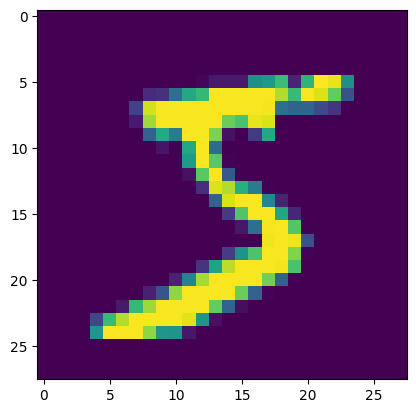

In [6]:
plt.imshow(x_train[0])
plt.show()

In [7]:
y_train[0]

5

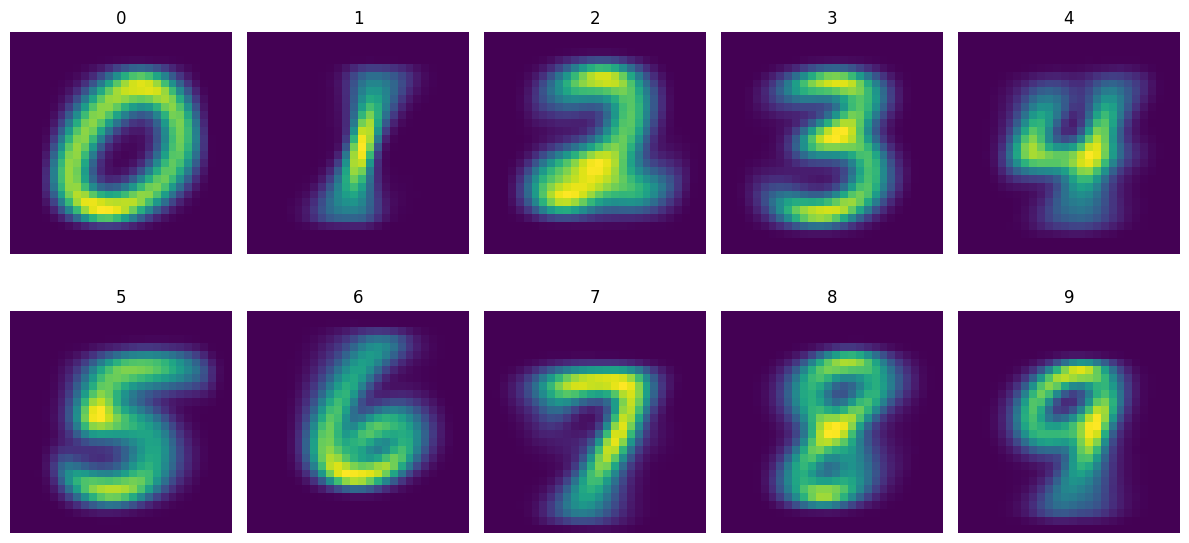

In [8]:
class_intensity = []
for i in set(y_train):    
    class_intensity += [x_train[np.where(y_train == i)].sum(axis=0)]

num_images = len(class_intensity)
num_rows = 2
num_cols = num_images // num_rows

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Flatten the axes array if it's more than 1D
if num_rows > 1:
    axes = axes.flatten()

# Loop through the images and plot on each subplot
for i in range(num_images):
    ax = axes[i]
    ax.imshow(class_intensity[i])
    ax.axis('off')

    # Set the title for the current subplot
    title = class_names[i]
    ax.set_title(title)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

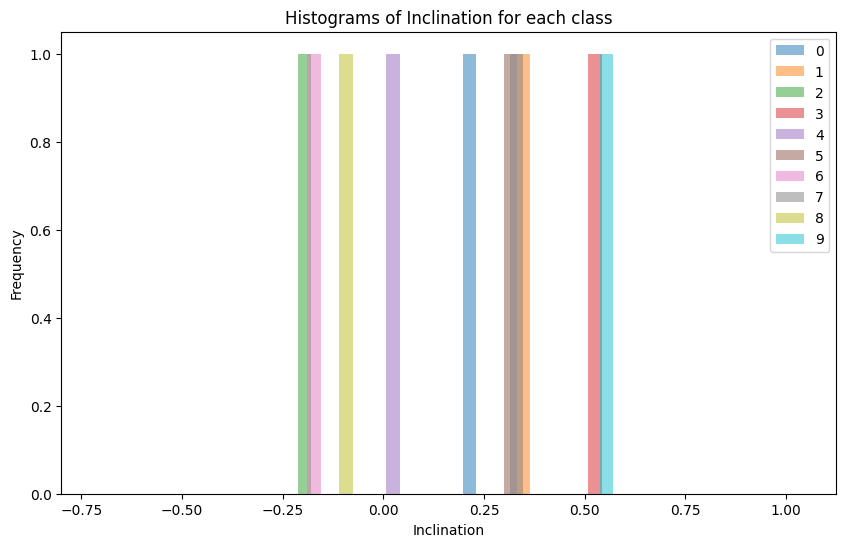

In [9]:
# Histograms of inclination for each class
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.hist(train_morpho[train_morpho['index'] == i]['slant'], bins=30, alpha=0.5, label=str(i))
plt.xlabel('Inclination')
plt.ylabel('Frequency')
plt.title('Histograms of Inclination for each class')
plt.legend()
plt.show()

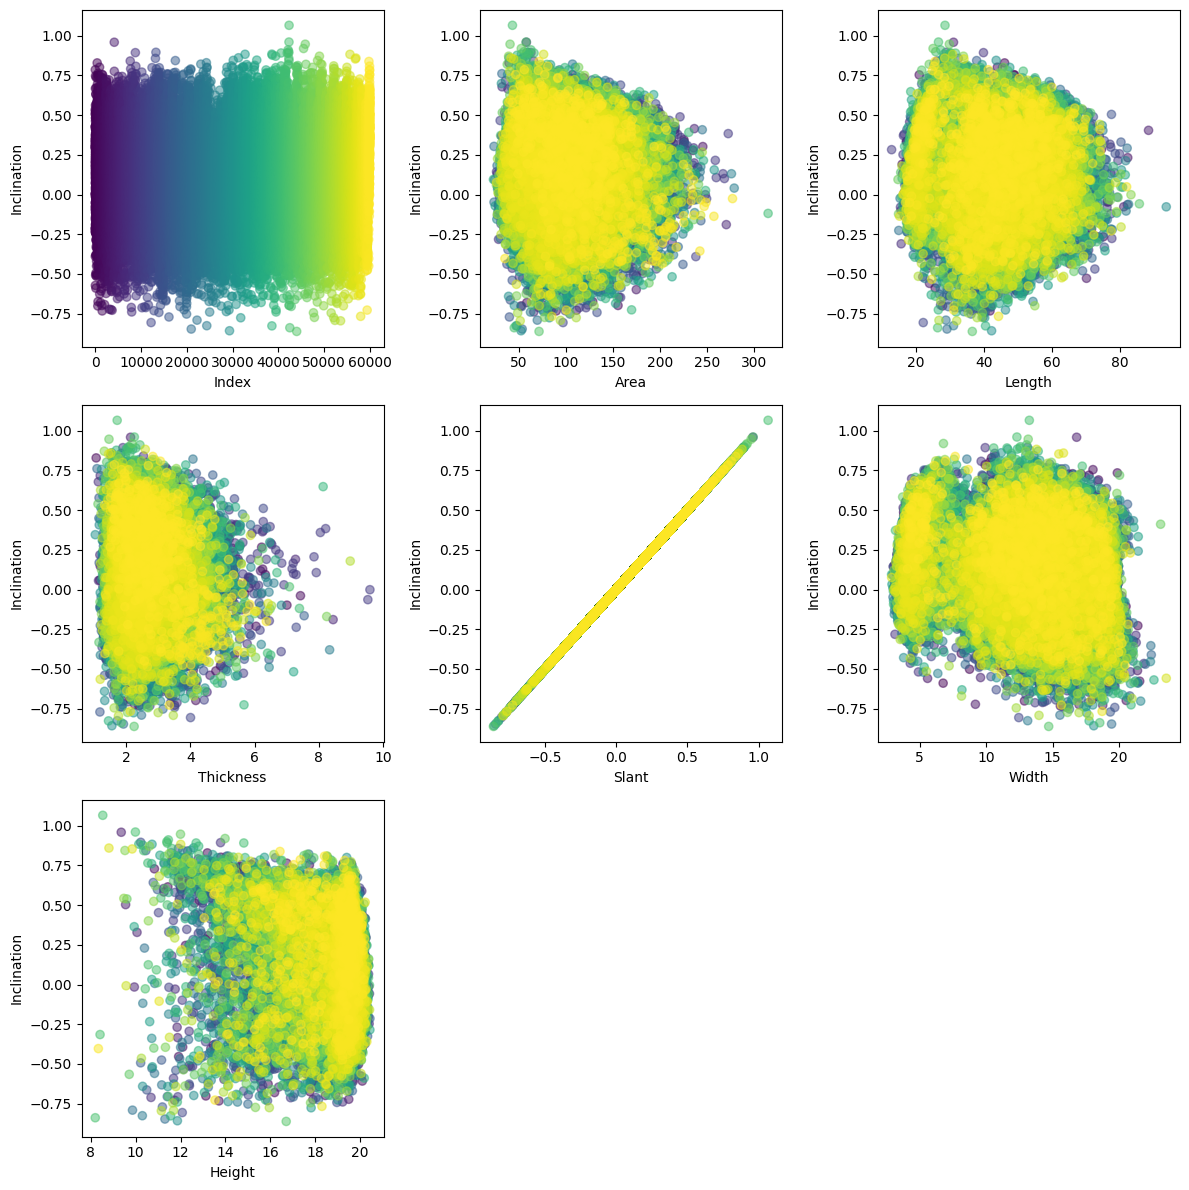

In [10]:
# Scatter plots between inclination and other morphological descriptors
morpho_descriptors = ['index', 'area', 'length', 'thickness', 'slant', 'width', 'height']
plt.figure(figsize=(12, 12))
for i, descriptor in enumerate(morpho_descriptors):
    plt.subplot(3, 3, i + 1)
    plt.scatter(train_morpho[descriptor], train_morpho['slant'], c=train_morpho['index'], cmap='viridis', alpha=0.5)
    plt.xlabel(descriptor.capitalize())
    plt.ylabel('Inclination')
plt.tight_layout()
plt.show()

## a.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session

In [12]:
# Prepare the input data
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0

In [13]:
# Define the MLP model
model_a = Sequential()
model_a.add(Dense(64, activation='relu', input_shape=(28, 28)))
model_a.add(Flatten())
model_a.add(Dense(32, activation='relu'))
model_a.add(Dense(1))

In [14]:
# Compile the model
model_a.compile(loss='mean_absolute_error', optimizer=Adam())

In [15]:
# Train the model
history_a = model_a.fit(x_train_normalized, train_morpho['slant'], epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0353 - val_loss: 0.0177
Epoch 2/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0145 - val_loss: 0.0120
Epoch 3/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0109 - val_loss: 0.0101
Epoch 4/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0093 - val_loss: 0.0094
Epoch 5/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0082 - val_loss: 0.0074
Epoch 6/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0074 - val_loss: 0.0077
Epoch 7/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 8/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 9/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 10/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0060 - val_loss: 0.007

In [16]:
# Evaluate the model on the test set
mae = model_a.evaluate(x_test_normalized, test_morpho['slant'])
print("MAE:", mae)

313/313 [==============================] - 0s 2ms/step - loss: 0.0069
MAE: 0.006919156759977341


In [17]:
clear_session()

## b.

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, Embedding, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [19]:
# Prepare the input data
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0
y_train_labels = y_train.astype(int)
y_test_labels = y_test.astype(int)

In [20]:
# Define the model architecture for image input
input_image = Input(shape=(28, 28))
activation_image_1 = Dense(64, activation='relu')(input_image)
flatten_image = Flatten()(activation_image_1)
activation_image_2 = Dense(32, activation='relu')(flatten_image)

In [21]:
# Define the model architecture for label input
input_label = Input(shape=(1,))
embedding_label = Embedding(10, 2)(input_label)
flatten_label = Flatten()(embedding_label)
activation_label_1 = Dense(16, activation='relu')(flatten_label)

In [22]:
# Concatenate the two inputs
concatenated = Concatenate()([activation_image_2, activation_label_1])
output = Dense(1)(concatenated)
model_b = Model(inputs=[input_image, input_label], outputs=output)

In [23]:
# Compile the model
model_b.compile(optimizer=Adam(), loss='mean_absolute_error')

In [24]:
# Train the model
history_b = model_b.fit([x_train_normalized, y_train_labels], train_morpho['slant'], epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0402 - val_loss: 0.0203
Epoch 2/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0158 - val_loss: 0.0141
Epoch 3/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0119 - val_loss: 0.0109
Epoch 4/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0098 - val_loss: 0.0107
Epoch 5/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 6/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 7/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 8/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 9/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 10/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0062 - val_loss: 0.0061

In [25]:
# Evaluate the model on the test set
mae = model_b.evaluate([x_test_normalized, y_test_labels], test_morpho['slant'])
print("MAE:", mae)

313/313 [==============================] - 0s 1ms/step - loss: 0.0060
MAE: 0.0060013532638549805


1/1 [==============================] - 0s 76ms/step


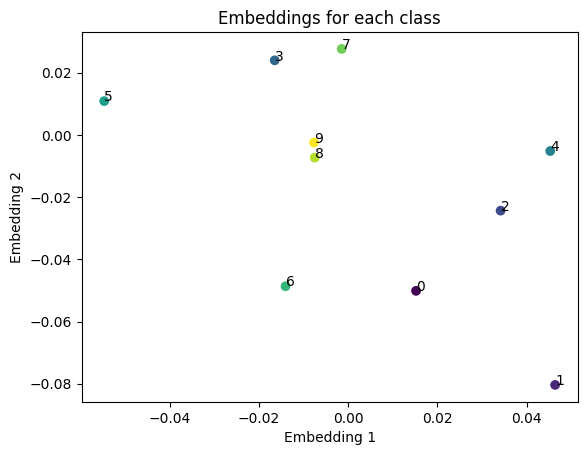

In [26]:
# Plot Embeddings
model_embedding = Model(inputs=input_label, outputs=embedding_label)
embeddings = model_embedding.predict(np.arange(len(class_names)))
plt.scatter(embeddings[:,:,0], embeddings[:,:,1], c=np.arange(len(class_names)), cmap='viridis')
for i in range(len(class_names)):
    plt.annotate(i, (embeddings[i,:, 0], embeddings[i,:, 1]))
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
plt.title('Embeddings for each class')
plt.show()

In [27]:
clear_session()

## c.

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [29]:
# Prepare the input data
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0
additional_variable_train = train_morpho['area']
additional_variable_test = test_morpho['area']

In [30]:
# Define the model architecture for image input
input_image = Input(shape=(28, 28))
activation_image_1 = Dense(64, activation='relu')(input_image)
flatten_image = Flatten()(activation_image_1)
activation_image_2 = Dense(32, activation='relu')(flatten_image)

In [31]:
# Define the model architecture for image input
input_additional = Input(shape=(1,))
norm_additional = BatchNormalization()(input_additional)
activation_additional_1 = Dense(16, activation='relu')(norm_additional)
dropout_additional = Dropout(0.125)(activation_additional_1)
activation_additional_2 = Dense(8, activation='relu')(dropout_additional)

In [32]:
# Concatenate the two inputs
concatenated = Concatenate()([activation_image_2, activation_additional_2])
output = Dense(1)(concatenated)
model_c = Model(inputs=[input_image, input_additional], outputs=output)

In [33]:
# Compile the model
model_c.compile(optimizer=Adam(), loss='mean_absolute_error')

In [34]:
# Train the model
history_c = model_c.fit([x_train_normalized, additional_variable_train], train_morpho['slant'], epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 4s 9ms/step - loss: 0.0398 - val_loss: 0.0173
Epoch 2/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0160 - val_loss: 0.0136
Epoch 3/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0117 - val_loss: 0.0099
Epoch 4/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0099 - val_loss: 0.0109
Epoch 5/10
375/375 [==============================] - 2s 7ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 6/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0077 - val_loss: 0.0080
Epoch 7/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0071 - val_loss: 0.0080
Epoch 8/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 9/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0065 - val_loss: 0.0071
Epoch 10/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0061 - val_loss: 0.0

In [35]:
# Evaluate the model on the test set
mae = model_c.evaluate([x_test_normalized, additional_variable_test], test_morpho['slant'])
print("MAE:", mae)

313/313 [==============================] - 0s 1ms/step - loss: 0.0065
MAE: 0.006480085197836161


In [36]:
clear_session()